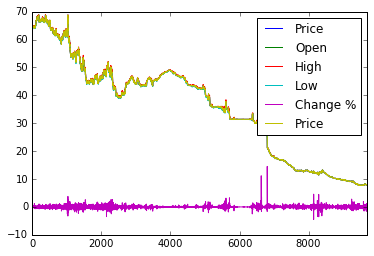

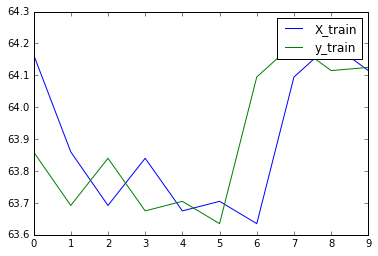

In [49]:
# Data: time-serie data from smartwatch or smartwatch data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
data_path = 'data/financial_data/USD_INR.csv'
data = pd.read_csv(data_path)

# Data: cleaning
# Getting rid of NaN
data = data.fillna(value=0.0)

# # Plotting the smartwatch data before scaling/batch normalization
data[:10000].plot() #x='dteday', y='cnt'

# data[:100].plot()
np.array(data).shape, np.array(data).dtype, np.array(data, dtype=None).dtype, 
# np.array(data[:, 1:], dtype=None).dtype

data = np.array(data)
plt.plot(data[:10000, 1], label='Price')
# plt.plot(data[:1000, 2], label='Open')
plt.legend()
plt.show()

# Sequence learning - seq2seq learning - Unsupervised Learning
# Training
X_train = np.array(data[0:-2, 1], dtype=float).reshape(-1, 1)
y_train = np.array(data[1:-1, 1], dtype=float).reshape(-1, 1)
X_train.shape, y_train.shape, X_train.dtype, y_train.dtype

# # type(X_train[2, 1])
# # X_train.shape
# np.array(X_train).dtype, np.array(X_train, dtype=None).dtype, np.array(X_train, dtype=float).dtype

plt.plot(X_train[:10], label='X_train')
plt.plot(y_train[:10], label='y_train')
plt.legend()
plt.show()

In [50]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, L, p_dropout): #, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.p_dropout = p_dropout
        # For text processing
        #         self.idx2char = idx2char
        #         self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[], 'valid': []}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []
        for _ in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m, train): # This can be used for training & testing
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)
        
        # Testing
        #         train = None
        #         # train = True
        #         # train = False
        #         if train:
        #             print('1')
        #         else:
        #             print('0')

        if train: # is True
            y, do_cache = l.dropout_forward(y, self.p_dropout)
            cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, do_cache)
        else:
            cache= None # This is not needed for test/ validation

        return y, h, cache

    def backward(self, dy, dh, cache): # This is only used for training
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, do_cache = cache
        
        dh_out = dh.copy()

        dy = l.dropout_backward(dy, do_cache)
        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])

        for X in X_train:
            X = X.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer], train=True)
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
                    
        return ys, caches
    
    def loss_function(self, y_pred, y_train):
        loss, dys = 0.0, []

        for y, Y in zip(y_pred, y_train):
            loss += l2_regression(y_pred=y, y_train=Y) #/ m: t or number of samples for taking the average
            dy = dl2_regression(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})

        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dy = dX.copy()
                
        return grads
    
    def test(self, X_seed, h, size):
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        ys = []
        X = X_seed.reshape(1, -1)
        for _ in range(size):
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer], train=False)
                X = y.copy()
            ys.append(y)
            
        return ys

In [51]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
#     for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for layer in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            # def loss_function(self, y_pred, y_train):
            loss, dys = nn.loss_function(y_pred=ys, y_train=y_mini)
            grads = nn.train_backward(dys, caches)
            
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)
            
            for layer in range(nn.L):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)

                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))

                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Validation loss to avoid overfitting & underfitting
            mb_num = len(minibatches) //2
            X_test, y_test = minibatches[mb_num]
            ys = nn.test(X_seed=X_test[0], size=mb_size, h=state)
            valid_loss, _ = nn.loss_function(y_pred=ys, y_train=y_test)
            nn.losses['valid'].append(valid_loss)
            
        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{}, train loss: {:.4f}, valid loss: {:.4f}'.format(iter, loss, valid_loss))

    return nn

In [ ]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 2 # depth
n_iter = 1000 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = 1 #len(char_to_idx) # vocab_size = len(char_to_idx)
p_dropout = 0.95 # dropout = 1- keep_prob, p = 1-q

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, p_dropout=p_dropout) #, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X_train, y_train=y_train, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.plot(net.losses['valid'], label='Validation loss')
plt.legend()
plt.show()

Iter-1, train loss: 364.1207, valid loss: 53371.5365
Iter-2, train loss: 1669.5734, valid loss: 43132.1400
Iter-3, train loss: 3042.0524, valid loss: 37105.9662
Iter-4, train loss: 4394.9936, valid loss: 33006.8739
Iter-5, train loss: 5487.2328, valid loss: 30028.0564
Iter-6, train loss: 6511.7035, valid loss: 27735.3047
Iter-7, train loss: 7282.0786, valid loss: 25905.5447
Iter-8, train loss: 8249.2714, valid loss: 24359.3531
Iter-9, train loss: 9050.1426, valid loss: 23025.7048
Iter-10, train loss: 9619.8420, valid loss: 21850.5497
Iter-11, train loss: 10449.1516, valid loss: 20803.4337
Iter-12, train loss: 11350.2268, valid loss: 19865.1234
Iter-13, train loss: 12050.6948, valid loss: 19014.5206
Iter-14, train loss: 12824.8797, valid loss: 18232.5409
Iter-15, train loss: 13210.6835, valid loss: 17501.4824
Iter-16, train loss: 13323.2759, valid loss: 16801.3430
Iter-17, train loss: 14571.1048, valid loss: 16131.9690
Iter-18, train loss: 14643.7734, valid loss: 15505.8767
Iter-19, tra

Iter-151, train loss: 8558.5695, valid loss: 151.8533
Iter-152, train loss: 7201.9596, valid loss: 152.6381
Iter-153, train loss: 12723.3455, valid loss: 154.2575
Iter-154, train loss: 12911.4476, valid loss: 156.1104
Iter-155, train loss: 12376.8623, valid loss: 159.8995
Iter-156, train loss: 12856.6785, valid loss: 158.1811
Iter-157, train loss: 11118.5647, valid loss: 158.0051
Iter-158, train loss: 7934.7534, valid loss: 158.1356
Iter-159, train loss: 8291.9134, valid loss: 159.0236
Iter-160, train loss: 22058.5149, valid loss: 160.0962
Iter-161, train loss: 14153.6521, valid loss: 161.8620
Iter-162, train loss: 12573.4248, valid loss: 163.3511
Iter-163, train loss: 7159.5810, valid loss: 164.3170
Iter-164, train loss: 13638.1750, valid loss: 166.2014
Iter-165, train loss: 9007.4174, valid loss: 165.7063
Iter-166, train loss: 18322.0109, valid loss: 164.6639
Iter-167, train loss: 20073.7200, valid loss: 164.5078
Iter-168, train loss: 15387.2677, valid loss: 165.1968
Iter-169, train 

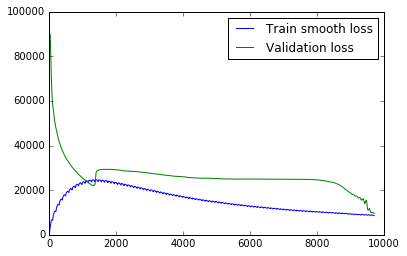

In [48]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.plot(net.losses['valid'], label='Validation loss')
plt.legend()
plt.show()

Iter-1, train loss: 448.3948, valid loss: 73265.5267
Iter-2, train loss: 13.2711, valid loss: 59299.5638
Iter-3, train loss: 158.4940, valid loss: 53350.7321
Iter-4, train loss: 444.5878, valid loss: 49340.7286
Iter-5, train loss: 775.7378, valid loss: 46192.3241
Iter-6, train loss: 1100.9398, valid loss: 43624.2927
Iter-7, train loss: 1373.7784, valid loss: 41526.1090
Iter-8, train loss: 1535.3776, valid loss: 39810.2068
Iter-9, train loss: 1511.3778, valid loss: 38381.9482
Iter-10, train loss: 1255.8772, valid loss: 37261.2765
Iter-11, train loss: 927.6613, valid loss: 36724.5053
Iter-12, train loss: 663.6693, valid loss: 37462.2223
Iter-13, train loss: 444.8353, valid loss: 38872.6378
Iter-14, train loss: 255.4302, valid loss: 39858.8774
Iter-15, train loss: 110.4671, valid loss: 40760.4642
Iter-16, train loss: 49.0310, valid loss: 41640.2880
Iter-17, train loss: 40.2444, valid loss: 37789.7516
Iter-18, train loss: 41.6412, valid loss: 32855.7552
Iter-19, train loss: 42.7662, valid 

Iter-158, train loss: 32.7299, valid loss: 200.7063
Iter-159, train loss: 32.2723, valid loss: 208.8745
Iter-160, train loss: 32.1006, valid loss: 249.7564
Iter-161, train loss: 32.2716, valid loss: 237.1294
Iter-162, train loss: 39.9685, valid loss: 312.0206
Iter-163, train loss: 49.6965, valid loss: 319.2507
Iter-164, train loss: 35.2581, valid loss: 313.9264
Iter-165, train loss: 30.9648, valid loss: 379.0986
Iter-166, train loss: 30.7319, valid loss: 368.3631
Iter-167, train loss: 30.3808, valid loss: 419.2959
Iter-168, train loss: 30.0265, valid loss: 443.4945
Iter-169, train loss: 29.5956, valid loss: 471.4377
Iter-170, train loss: 29.2497, valid loss: 505.4736
Iter-171, train loss: 28.8744, valid loss: 535.8037
Iter-172, train loss: 28.4974, valid loss: 567.3021
Iter-173, train loss: 28.1222, valid loss: 600.7865
Iter-174, train loss: 27.7327, valid loss: 628.1783
Iter-175, train loss: 27.3586, valid loss: 665.2121
Iter-176, train loss: 26.9601, valid loss: 687.0243
Iter-177, tr

Iter-315, train loss: 6.2844, valid loss: 3497.7872
Iter-316, train loss: 2.2062, valid loss: 883.0094
Iter-317, train loss: 2.1528, valid loss: 13336.3995
Iter-318, train loss: 1.7313, valid loss: 4141.3547
Iter-319, train loss: 1.9072, valid loss: 13911.1141
Iter-320, train loss: 2.4141, valid loss: 7069.4609
Iter-321, train loss: 2.7031, valid loss: 14088.3817
Iter-322, train loss: 2.8690, valid loss: 7066.1373
Iter-323, train loss: 2.5680, valid loss: 14279.1312
Iter-324, train loss: 2.5143, valid loss: 5574.5243
Iter-325, train loss: 2.2711, valid loss: 14466.5663
Iter-326, train loss: 2.1861, valid loss: 3429.1639
Iter-327, train loss: 2.0205, valid loss: 14416.2772
Iter-328, train loss: 1.7410, valid loss: 1372.1512
Iter-329, train loss: 1.4102, valid loss: 1166.0392
Iter-330, train loss: 1.3121, valid loss: 15279.4864
Iter-331, train loss: 1.5626, valid loss: 9834.8699
Iter-332, train loss: 3.2139, valid loss: 15898.8824
Iter-333, train loss: 6.1619, valid loss: 13238.4616
Iter

Iter-472, train loss: 2.1104, valid loss: 9178.1129
Iter-473, train loss: 3.6012, valid loss: 28559.5006
Iter-474, train loss: 8.1511, valid loss: 50382.4490
Iter-475, train loss: 10.1023, valid loss: 20623.4799
Iter-476, train loss: 3.2545, valid loss: 9582.2024
Iter-477, train loss: 2.8190, valid loss: 5873.1338
Iter-478, train loss: 3.0980, valid loss: 3763.4950
Iter-479, train loss: 2.1869, valid loss: 18304.5248
Iter-480, train loss: 2.2806, valid loss: 3803.4740
Iter-481, train loss: 2.7178, valid loss: 12124.8811
Iter-482, train loss: 2.4053, valid loss: 1312.0004
Iter-483, train loss: 2.2882, valid loss: 1437.3430
Iter-484, train loss: 2.0174, valid loss: 1504.9932
Iter-485, train loss: 2.0599, valid loss: 1320.6347
Iter-486, train loss: 2.1722, valid loss: 16910.4099
Iter-487, train loss: 2.2195, valid loss: 223.0042
Iter-488, train loss: 2.1752, valid loss: 2488.4409
Iter-489, train loss: 2.1505, valid loss: 25438.8851
Iter-490, train loss: 3.9957, valid loss: 10645.5029
Iter

Iter-629, train loss: 2.3413, valid loss: 11769.2749
Iter-630, train loss: 4.3419, valid loss: 30831.5377
Iter-631, train loss: 5.0037, valid loss: 11409.1793
Iter-632, train loss: 4.6804, valid loss: 273.3879
Iter-633, train loss: 1.9008, valid loss: 25784.3250
Iter-634, train loss: 3.2002, valid loss: 8894.8403
Iter-635, train loss: 3.3504, valid loss: 18680.6255
Iter-636, train loss: 2.0232, valid loss: 4368.4271
Iter-637, train loss: 2.6583, valid loss: 3159.0251
Iter-638, train loss: 1.7109, valid loss: 232.7791
Iter-639, train loss: 1.7383, valid loss: 642.4408
Iter-640, train loss: 1.6187, valid loss: 1282.6516
Iter-641, train loss: 1.6675, valid loss: 766.3609
Iter-642, train loss: 1.6772, valid loss: 4226.3756
Iter-643, train loss: 1.6944, valid loss: 491.1071
Iter-644, train loss: 1.6590, valid loss: 4013.6542
Iter-645, train loss: 1.8369, valid loss: 26437.7645
Iter-646, train loss: 2.6824, valid loss: 2955.7633
Iter-647, train loss: 2.6070, valid loss: 4331.2692
Iter-648, t

Iter-786, train loss: 1.8417, valid loss: 11306.4028
Iter-787, train loss: 1.8553, valid loss: 20536.5084
Iter-788, train loss: 1.8771, valid loss: 10441.0832
Iter-789, train loss: 1.9604, valid loss: 20173.2060
Iter-790, train loss: 1.9212, valid loss: 9366.5330
Iter-791, train loss: 1.9903, valid loss: 18685.3774
Iter-792, train loss: 1.7882, valid loss: 7259.8424
Iter-793, train loss: 1.8070, valid loss: 14077.7158
Iter-794, train loss: 1.5267, valid loss: 4105.7848
Iter-795, train loss: 1.4532, valid loss: 2477.8696
Iter-796, train loss: 1.1504, valid loss: 70.7386
Iter-797, train loss: 1.0715, valid loss: 195.6506
Iter-798, train loss: 1.0081, valid loss: 5742.4400
Iter-799, train loss: 1.1915, valid loss: 2567.1588
Iter-800, train loss: 1.2778, valid loss: 1942.8643
Iter-801, train loss: 1.0327, valid loss: 5956.8992
Iter-802, train loss: 1.2805, valid loss: 9328.8096
Iter-803, train loss: 2.6450, valid loss: 30634.5019
Iter-804, train loss: 3.6954, valid loss: 6486.4147
Iter-805

Iter-943, train loss: 1.5424, valid loss: 18399.6811
Iter-944, train loss: 1.3067, valid loss: 7523.5569
Iter-945, train loss: 1.2623, valid loss: 11136.8801
Iter-946, train loss: 0.9906, valid loss: 3715.1811
Iter-947, train loss: 0.8446, valid loss: 1331.2909
Iter-948, train loss: 0.6272, valid loss: 419.1029
Iter-949, train loss: 0.5778, valid loss: 1406.4921
Iter-950, train loss: 0.6107, valid loss: 5948.1412
Iter-951, train loss: 0.7356, valid loss: 1141.7418
Iter-952, train loss: 0.6790, valid loss: 1233.4455
Iter-953, train loss: 0.5587, valid loss: 20771.8468
Iter-954, train loss: 1.2950, valid loss: 8908.4732
Iter-955, train loss: 2.7553, valid loss: 26632.1988
Iter-956, train loss: 1.5332, valid loss: 9409.2223
Iter-957, train loss: 0.6841, valid loss: 9691.3962
Iter-958, train loss: 2.5835, valid loss: 30475.7215
Iter-959, train loss: 4.5013, valid loss: 85267.3699
Iter-960, train loss: 5.2435, valid loss: 22322.0331
Iter-961, train loss: 1.8011, valid loss: 15482.2185
Iter-

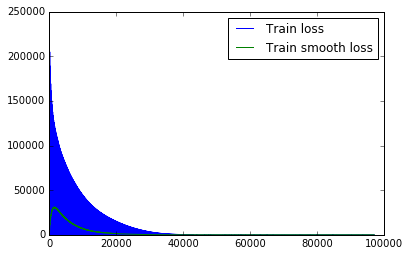

In [10]:
# # Hyper-parameters
# time_step = 100 # width, minibatch size and test sample size as well
# num_layers = 1 # depth
# n_iter = 200 # epochs
# alpha = 1e-4 # learning_rate
# print_after = 1 # n_iter//10 # print training loss, valid, and test
# num_hidden_units = 64 # num_hidden_units in hidden layer
# num_input_units = 1 #len(char_to_idx) # vocab_size = len(char_to_idx)
# p_dropout = 0.95 # dropout = 1- keep_prob, p = 1-q

# # Build the network and learning it or optimizing it using SGD
# net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers) #, char2idx=char_to_idx, idx2char=idx_to_char)

# # Start learning using BP-SGD-ADAM
# adam_rnn(nn=net, X_train=X_train, y_train=y_train, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()